In [22]:
import astropy.table as table
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import click

import sys
if 'SuperBoL' not in sys.path:
    sys.path.append('SuperBoL')
import superbol
from superbol.fit_blackbody import bb_fit_parameters, bb_flux_nounits
from superbol.fbol import (ir_correction, uv_correction_blackbody,
                           uv_correction_linear)
from superbol.fbol import integrate_fqbol as fqbol_trapezoidal

from astropy.cosmology import Planck15 as cosmo
import astropy.constants as const

redshift = 0.00449
dist = cosmo.luminosity_distance(redshift).to(u.cm)
dist_cm = dist.value
dist_pc = dist.to(u.pc).value
dist_mod = 5*np.log10(dist_pc) - 5

In [12]:
## PTF13bvn dataset
ptf_raw = table.Table.read('../data/comparison/PTF13bvn/raw_lc.dat', format='ascii')
ptf_raw.pprint()
jd_grid = np.linspace(2456462, 2456520)
ptf_interp = {'time': jd_grid}
for band in 'UBVRIg':
    idx = ptf_raw['band'] == band
    mag = ptf_raw['mag'][idx]
    jd = ptf_raw['JD'][idx]
    if band == 'g':
        jd_max_idx = np.argmin(mag)
        jd_max = jd[jd_max_idx]
    ptf_interp[band] = np.interp(jd_grid, jd, mag)
print('JD max: %f' % jd_max)
ptf_interp_t = table.Table(ptf_interp)
ptf_interp_t

     JD      mag   mag_err band telescope
----------- ------ ------- ---- ---------
2456459.738 18.611    0.05    r       P48
2456459.791 18.619    0.05    r       P48
 2456460.74 17.612    0.04    r       P48
2456460.788 17.552    0.04    r       P48
2456460.877 17.668    0.01    i       P60
2456460.878   17.5    0.01    r       P60
2456460.883 17.832    0.01    g       P60
2456461.251 17.906   0.018    B     LCOGT
 2456461.26 17.328   0.015    V     LCOGT
2456461.334 17.627   0.009    g     LCOGT
        ...    ...     ...  ...       ...
 2456685.74 20.349    0.08    r       NOT
2456698.724 21.377   0.077    g       NOT
2456698.739 20.576   0.094    r       NOT
2456721.651 21.811     0.1    g      P200
2456721.663 20.991   0.203    r      P200
2456721.674  20.07    0.15    i       NOT
2456752.955 21.419    0.21    r       NOT
2456752.963 22.231   0.311    g       NOT
2456779.508 22.941   0.289    g       NOT
2456779.523 21.712   0.177    r       NOT
2456813.448 21.995   0.281    r   

<Table length=50>
       time                U          ...         I                  g         
     float64            float64       ...      float64            float64      
------------------ ------------------ ... ------------------ ------------------
         2456462.0 17.561450151027437 ... 16.675474464601024 17.443967999953774
2456463.1836734693 17.198955326494126 ...  16.32908658936953 17.057588238317123
2456464.3673469387 16.800329896974077 ...  15.98722503728566  16.68485964225539
 2456465.551020408  16.40970263509623 ... 15.727910581292772 16.358978470128378
2456466.7346938774 16.123754816664327 ... 15.535772285772953 16.143155102081597
2456467.9183673467 15.837806998232427 ... 15.372430244930554 15.948534286720738
 2456469.102040816 15.699302986496988 ... 15.276552693913224 15.859824239917533
 2456470.285714286 15.770227879785368 ...  15.19242883425265 15.711762646474815
2456471.4693877553 15.841152773045849 ... 15.116209686282494  15.63910644879554
2456472.6530612246 15.912077666306327 ... 15.039990538312338 15.629903277674655
               ...                ... ...                ...                ...
2456509.3469387754 18.981806867867405 ...   15.9600888337379  17.80481188537086
2456510.5306122447  19.02229274967988 ... 15.926320371393553  17.79315717491752
 2456511.714285714 19.066023041465883 ...  16.06305895692003 17.761745945948878
 2456512.897959184  19.11211957064167 ... 16.051671237246886 17.812515306084507
2456514.0816326533 19.166070975765432 ...  16.07981702227251  17.83724755040148
2456515.2653061226  19.22002238088919 ...  16.12016952690693 17.887019752860336
 2456516.448979592 19.273973786012952 ... 16.160522031541355  17.85752526253259
2456517.6326530613  19.32792519113671 ... 16.200874536175775  17.87535023325671
2456518.8163265307  19.17362875684401 ...  16.19182806123812 17.917670625623824
         2456520.0             19.123 ...  16.23411438233644 17.917294003864427

In [9]:
lyman_pbc_params = np.array([
    0.168, -0.407, -0.608, # c0 c1 c2
    0.074 # rms
])

lyman_bc_params = np.array([
    0.054, -0.195, -0.719, # c0 c1 c2
    0.076 # rms
])

lyman_pbc_params_gi = np.array([
    0.051, -0.511, -0.195, # c0 c1 c2
    0.055 # rms
])

lyman_bc_params_gi = np.array([
    -0.029, -0.404, -0.230, # c0 c1 c2
    0.060 # rms
])

lyman_bc_cooling_params = np.array([
    -0.146, 0.479, 2.257, # c0 c1 c2
    0.078 # rms
])

lyman_bc_params_vr = np.array([
    0.197, -0.183, -0.419, # c0 c1 c2
    0.101 # rms
])

COLOR_RANGES = {
    'pbc_gr': (-0.3, 1.0),
    'bc_gr': (-0.3, 1.0),
    'pbc_gi': (-0.8, 1.1),
    'bc_gi': (-0.8, 1.1),
    'bc_vr': (-0.2, 0.7)
}

VARIANTS = {
    'pbc_gr': ('g', 'r'),
    'bc_gr': ('g', 'r'),
    'pbc_gi': ('g', 'i'),
    'bc_gi': ('g', 'i')
}

def compute_bol_mag(mag_g, mag_r, method):
    if method == 'pbc_gr':
        c0, c1, c2, rms = lyman_pbc_params
    elif method == 'bc_gr':
        c0, c1, c2, rms = lyman_bc_params
    elif method == 'pbc_gi':
        c0, c1, c2, rms = lyman_pbc_params_gi
    elif method == 'bc_gi':
        c0, c1, c2, rms = lyman_bc_params_gi
    elif method == 'bc_vr':
        c0, c1, c2, rms = lyman_bc_params_vr
    elif method == 'cooling_gr':
        c0, c1, c2, rms = lyman_bc_cooling_params
    else:
        raise ValueError('Unknown method: %s' % method)

    dmag = mag_g - mag_r

    # validate color range
    color_min = dmag.min()
    color_max = dmag.max()

    if color_min < COLOR_RANGES[method][0]:
        print('* WARN: color in lc exceeds lyman (min lc = %f < %f)' % (color_min, COLOR_RANGES[method][0]))
    if color_max > COLOR_RANGES[method][1]:
        print('* WARN: color in lc exceeds lyman (max lc = %f > %f)' % (color_max, COLOR_RANGES[method][1]))
    
    bol_correction = c0 + c1*dmag + c2*dmag ** 2
    
    return mag_g + bol_correction

def convert_luminosity(abs_mag):
    luminosity = (const.L_sun.cgs.value)*10 ** ((4.74 - abs_mag)/2.5)
    return luminosity

In [24]:
EXTINCTION_COEFF = {
    'g': 3.303,
    'r': 2.285,
    'i': 1.698,
    'z': 1.263,
    # from https://irsa.ipac.caltech.edu/workspace/TMP_3mtiHn_9142/DUST/SN2004aw.v0001/extinction.html
    'U': 4.107,
    'B': 3.641,
    'V': 2.682,
    'R': 2.119,
    'I': 1.516,
    'J': 0.723,
    'H': 0.460,
    'K': 0.310,
    'time': 0
}
ebv = 0.05 + 0.08 # from Fremling paper

lc = ptf_interp_t
bol_vr = compute_bol_mag(lc['V']-EXTINCTION_COEFF['V']*ebv, lc['R']-EXTINCTION_COEFF['R']*ebv, 'bc_vr')
lum_lyman = convert_luminosity(bol_vr-dist_mod)

Text(0, 0.5, 'Ratio x/Lyman')

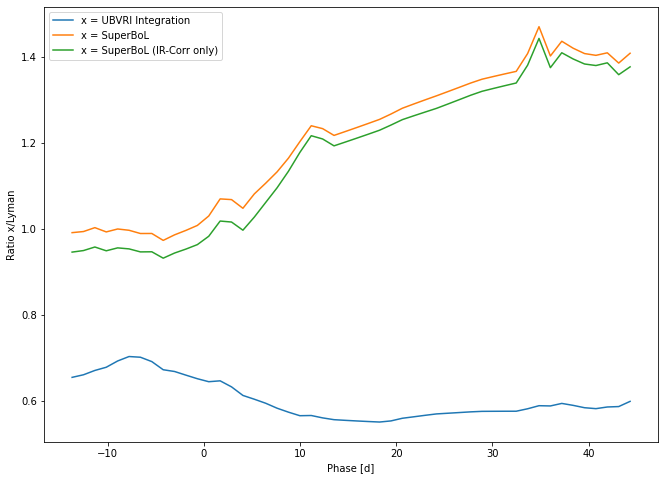

In [25]:
INS_VEGA = [
    #('U', 3492.67, 778.49, 3.58033e-9),
    #('B', 4377.97, 978.33, 6.44317e-9),
    #('V', 5439.64, 744.99, 3.72255e-9),
    #('R', 6457.54, 1298.29, 2.28509e-9),
    #('I', 8895.81, 3155.25, 9.19679e-10),
    ('U', 3610.30, 597.48, 3.93713e-9),
    ('B', 4360.79, 1041.07, 6.31306e-9),
    ('V', 5309.53, 1009.49, 3.98953e-9),
    ('R', 6632.62, 1509.99, 2.13438e-9),
    ('I', 8554.71, 2784.03, 1.00315e-9),
    #('J', 12536.58, 2886.97, 3.0717e-10),
    #('H', 16519.80, 2959.98, 1.14771e-10),
    #('K', 21638.30, 2745.48, 4.30954e-11)
]

INS=INS_VEGA
int_bands = [x[0] for x in INS]
cent_wave = [x[1] for x in INS]
fwhm = [x[2] for x in INS]
zero_flux = [x[3] for x in INS]

plt.figure(figsize=(11,8))
lum_int = np.empty(len(lum_lyman))
lum_superbol = np.empty(len(lum_lyman))
lum_superbol_ir = np.empty(len(lum_lyman))
temps = np.empty(len(lum_lyman))
for i,row in enumerate(lc):
    mags = list(map(lambda band: row[band]-EXTINCTION_COEFF[band]*ebv, int_bands))
    #mag_errs = list(map(lambda band: row['e%s' % band]-EXTINCTION_COEFF[band]*ebv, int_bands))
    fluxes = np.array(zero_flux)*10**(-0.4*np.array(mags))
    flux_errs = np.abs(fluxes * -0.4 * np.log(10) * 0.02)
    
    # simple direction integration
    f_qbol = np.trapz(fluxes, cent_wave)
    lums_qbol = 4*np.pi*dist_cm**2*f_qbol
    lum_int[i] = lums_qbol
    
    # do superbol integration
    f_qbol_sb, fqbol_err = fqbol_trapezoidal(cent_wave, fluxes, flux_errs)
    
    # now do the superbol thing
    temperature, angular_radius, perr = bb_fit_parameters(cent_wave, fluxes, flux_errs)
    temps[i] = temperature
    temperature_err = perr[0]
    angular_radius_err = perr[1]
    longest_wl = np.amax(cent_wave)
    shortest_wl = np.amin(cent_wave)
    shortest_flux = np.amin(fluxes)
    shortest_flux_err = np.amin(flux_errs)
    ir_corr, ir_corr_err = ir_correction(temperature, temperature_err, angular_radius, angular_radius_err, longest_wl)
    U_wl = cent_wave[0]
    U_flux = fluxes[0]
    if U_flux < bb_flux_nounits(U_wl, temperature, angular_radius):
        uv_corr, uv_corr_err = uv_correction_linear(
            shortest_wl, shortest_flux, shortest_flux_err)
    else:
        uv_corr, uv_corr_err = uv_correction_blackbody(
            temperature, temperature_err, angular_radius,
            angular_radius_err, shortest_wl)
    lum_superbol[i] = 4*np.pi*dist_cm**2*(f_qbol_sb + ir_corr + uv_corr)
    lum_superbol_ir[i] = 4*np.pi*dist_cm**2*(f_qbol_sb + ir_corr)
    
plt.plot(lc['time']-jd_max, lum_int/lum_lyman, label='x = UBVRI Integration')
plt.plot(lc['time']-jd_max, lum_superbol/lum_lyman, label='x = SuperBoL')
plt.plot(lc['time']-jd_max, lum_superbol_ir/lum_lyman, label='x = SuperBoL (IR-Corr only)')
#plt.plot(lc['time'], temps)
plt.legend()
plt.xlabel('Phase [d]')
plt.ylabel('Ratio x/Lyman')

Text(0, 0.5, 'Temperature [K]')

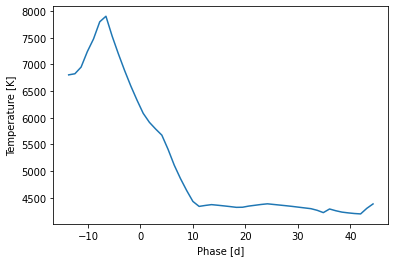

In [26]:
plt.plot(lc['time']-jd_max, temps)
plt.xlabel('Phase [d]')
plt.ylabel('Temperature [K]')